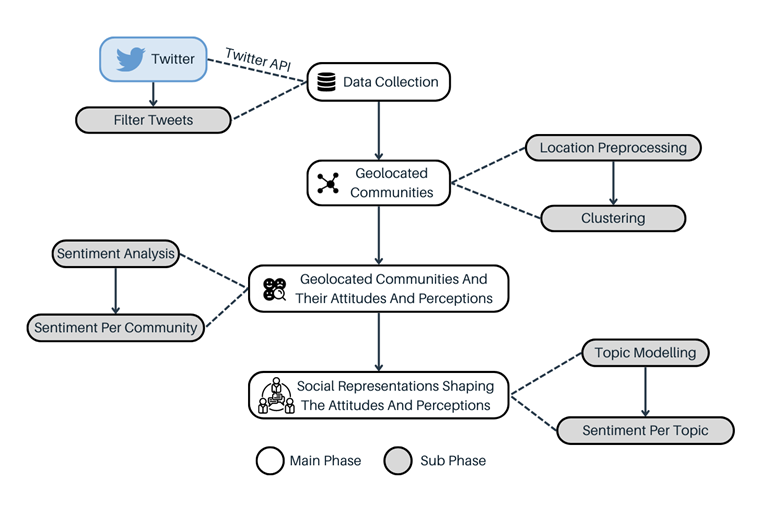

In [1]:
#https://www.tweepy.org/
import tweepy
import pandas as pd
import dataframe_image as dfi
import seaborn as sns
import numpy as np
import os
from geopy.geocoders import Nominatim
from tqdm import tqdm
tqdm.pandas()
import folium
from folium.plugins import HeatMap
from sklearn.neighbors import DistanceMetric
import math
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import geopandas as gpd
from matplotlib import cm
import matplotlib.pyplot as plt
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
from cleantext import clean
from nltk import word_tokenize
import contractions
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #good for social media
from nltk.corpus import stopwords
from gensim.models import Phrases
import numpy as np
from PIL import Image 
from wordcloud import WordCloud
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models
import hdbscan
import umap
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
import requests
from IPython.display import display
from pandas.io.formats.style import Styler
pd.set_option('display.max_colwidth', -1)

def display_df(df):
    styler = Styler(df)
    styler.set_properties(**{'font-family': 'Times New Roman', 'text-align': 'center', 'background-color': 'white', 'font-size': '13px'})
    styler.set_table_styles([dict(selector="th", props=[('text-align', 'center'), ('font-family', 'Times New Roman'), ('font-size', '14px')])])
    display(styler)

C:\Users\arthu\AppData\Roaming\Python\Python39\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\arthu\AppData\Roaming\Python\Python39\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\arthu\AppData\Roaming\Python\Python39\site-packages\umap\distances.

# Data Collection

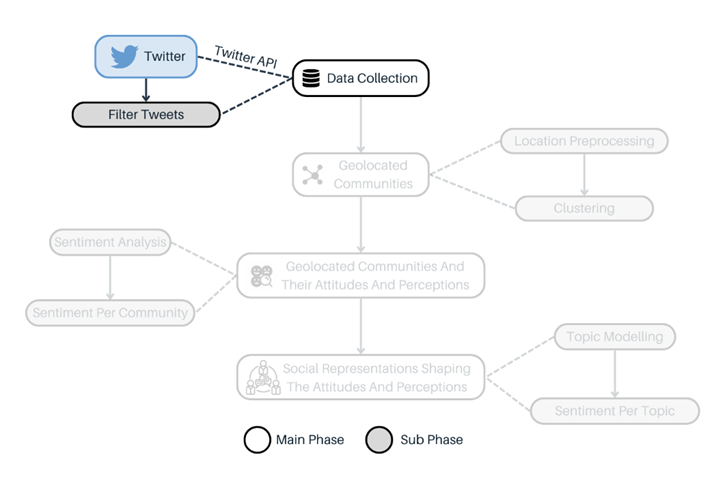

**Retreive tweets with twitter API**

In [9]:
bearer_token="AAAAAAAAAAAAAAAAAAAAADZgnAEAAAAA4ZO2nGfUYwhwvVaC7vhOG6nwYSg%3Db8U1sJd5d5nlIchflA7yvBw57kObIVVzNtUCSXD1QSGd3MVNGU"
auth = tweepy.OAuth2BearerHandler(bearer_token)
api = tweepy.API(auth)

In [24]:
query= str(input("What word do you want to scrape on?\n#keto, #vegan, #vegetarian, #healthylifestyle, #paleo, #lowcarbdiet, #lactosefree, #lowfat, #plantbased\n")) 
amount=int(input("How many tweets do you want to scrape?\n"))
dictionary=dict()
dictionary["author"]=[]
dictionary["totalstatuses"]=[]
dictionary["totallikes"]=[]
dictionary["followers"]=[]
dictionary["datetime"]=[]
dictionary["text"]=[]
dictionary["location"]=[]
dictionary["likes"]=[]
dictionary["retweets"]=[]
dictionary["lang"]=[]
tweets = tweepy.Cursor(api.search_tweets, q=query,tweet_mode="extended",count=100).items(amount)
count=0
for i in tweets:
    #https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/user
    dictionary["author"].append(i.user.screen_name)
    dictionary["totalstatuses"].append(i.user.statuses_count)
    dictionary["totallikes"].append(i.user.favourites_count)
    dictionary["followers"].append(i.user.followers_count)
    dictionary["datetime"].append(i.created_at)
    dictionary["text"].append(i.full_text)
    dictionary["location"].append(i.user.location)
    dictionary["likes"].append(i.favorite_count)
    dictionary["retweets"].append(i.retweet_count)
    dictionary["lang"].append(i.lang)
    count+=1
    print(count, end="\r")
    
tweets_df=pd.DataFrame(dictionary)

# Save the dataframe as a JSON file
end=str(tweets_df.iloc[1,4])[0:10].replace("-","")
start=str(tweets_df.iloc[len(tweets_df)-1,4])[0:10].replace("-","")
filename= r"Data/" +query + "from" + start + "until" + end + ".json"
tweets_df.to_json(filename)

What word do you want to scrape on?
#keto, #vegan, #vegetarian, #healthylifestyle, #paleo, #lowcarbdiet, #lactosefree, #lowfat, #plantbased
#keto
How many tweets do you want to scrape?
100


In [2]:
topics="\n".join(list(set([s[:-30] for s in os.listdir("Data") if ".json" in s])))
query=input("Which tweets do you analyze? Choose from: \n" + topics + "\n")
files=["Data/" + s for s in os.listdir("Data") if query in s]
tweets_df= pd.read_json(files[0])
for i in range(1, len(files)):
    tweets_df=pd.concat([tweets_df, pd.read_json(files[i])])
tweets_df=tweets_df[["datetime", "author", "text", "location", "lang"]]

Which tweets do you analyze? Choose from: 
#lactosefree
#lowfat
#vegetarian
#healthylifestyle
#keto
#vegan
#paleo
#plantbased
#lowcarbdiet
#vegan


**Filter tweets**             

In [121]:
#remove retweets
tweets_df = tweets_df[~tweets_df["text"].str.startswith('RT')]
#remove duplicates because the timeframe could overlap or people might post the same thing multiple times
tweets_df = tweets_df.drop_duplicates(subset='text', keep='first')
# sort by date just for the sake of having the tweets in chronological order
tweets_df = tweets_df.sort_values("datetime")

In [123]:
# classifier will be used to give a score of how much the tweet is about the hashtag.
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7")
labels = ["food"] #If the tweets is about food in general we keep it

#based on score assigned by the classifier determine if it is about the topic or not
def subjectfilter(text):
    try:
        text= text.replace(query, " ") #if "#vegan" occurs in the text then the classifier will alway think that the tweet is about veganism so would be biased
        result=classifier(text, labels)
        score=result["scores"][0]
        abouthashtag="yes"
        if score < 0.5: #treshhold
            abouthashtag="no"
        return abouthashtag
    except:
        return "no"

In [124]:
tweets_df["abouthashtag"]=tweets_df["text"].progress_apply(subjectfilter)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.21it/s]


In [128]:
tweets_df=tweets_df[tweets_df["abouthashtag"]=="yes"]
tweets_df=tweets_df[["datetime", "author", "text", "location", "lang"]]

# Geolocated Communities

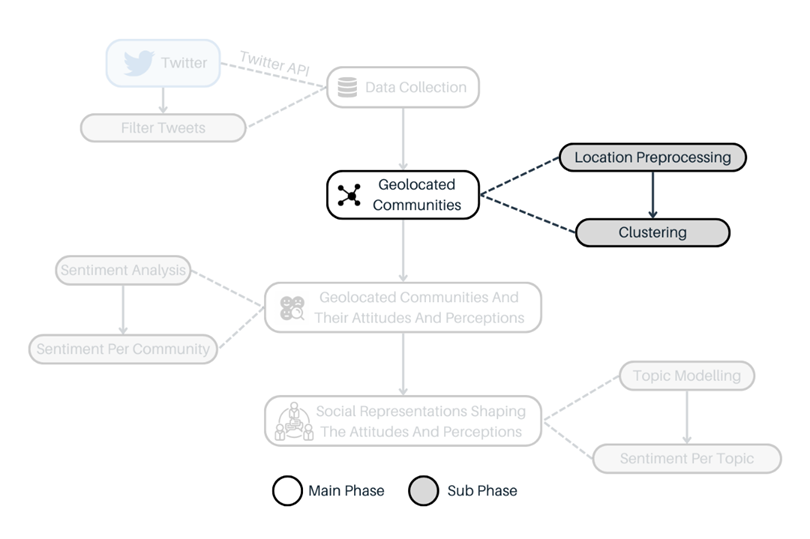

**Location Preprocessing**

In [130]:
#We want to detect communities of users not communities of tweets
users_df=tweets_df.drop_duplicates(subset='author', keep='first')
#Only select the user and their location
users_df=users_df[["author", "location"]]
#we only include twitter users that that have entered their location
users_df = users_df[users_df['location'] != ""]

In [133]:
# Retrieve a list of countries and their capitals using the REST Countries API
response = requests.get('https://restcountries.com/v3.1/all')
data = response.json()

# Create a dictionary that maps country names to their capital cities
country_to_city = {}
for country in data:
    # Check if the country has a capital city defined
    if 'capital' in country:
        # Get the country name and capital city
        name = country['name']['common'].lower()
        capital = country['capital'][0]

        # Add the country name and capital city to the dictionary
        country_to_city[name] = capital

# Define a custom function to replace country names with their capital cities
def replace_country_with_city(location):
    # Convert the location to lowercase
    location = location.lower()

    # Check if the location is a country name
    if location in country_to_city:
        # Replace the country name with its capital city
        return country_to_city[location]
    else:
        # Return the original location
        return location

In [136]:
users_df['location'] = users_df['location'].progress_apply(replace_country_with_city)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


In [138]:
#We extract the coordinates from the manualy entered location
def extractCoordinates(location):
    try:
        geolocator = Nominatim(user_agent="Arthur")
        coordinates = geolocator.geocode(location)
        coordinates = [coordinates.latitude, coordinates.longitude]
    except:
        #if we couldn't find a location we add an empty string to the list
        coordinates=''
    return coordinates

In [139]:
users_df["coordinates"]=users_df["location"].progress_apply(extractCoordinates)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


In [140]:
#Remove users that manually entered locations for which we couldn't find the coordinates
users_df=users_df[users_df["coordinates"] != ""]
users_df=users_df[["author", "coordinates"]]

In [20]:
# Convert latitude and longitude to radians
latitude = np.radians([float(coord[0]) for coord in users_df['coordinates']])
longitude = np.radians([float(coord[1]) for coord in users_df['coordinates']])

# Create a numpy array of latitude and longitude coordinates
coordinates_array = np.column_stack((latitude, longitude))

# Calculate the pairwise distance matrix using the Haversine formula
dist = DistanceMetric.get_metric('haversine')
distance_matrix = dist.pairwise(coordinates_array)

# Convert the distance matrix from radians to kilometers
R = 6371 # Radius of the Earth in kilometers
distance_matrix *= R

**Community Detection**                                 

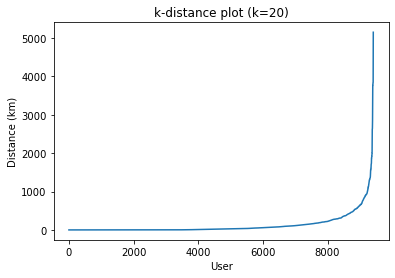

In [21]:
k = 20 # specify the value of k

# Find the distance to the k-th nearest neighbor for each point
k_distances = np.sort(distance_matrix, axis=1)[:, k]

# Sort the k-distances in ascending order
k_distances_sorted = np.sort(k_distances)

# Plot the sorted k-distances against their indices
plt.plot(k_distances_sorted)
plt.xlabel('User')
plt.ylabel(f'Distance (km)')
plt.title(f'k-distance plot (k={k})')
plt.show()

In [22]:
k_distances_sorted[8747]

464.27044627476846

In [23]:
eps=465

In [24]:
# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=k, metric='precomputed')
dbscan.fit(distance_matrix)

# Retrieve cluster labels
cluster_labels = dbscan.labels_

# Add cluster labels to the DataFrame
users_df['cluster_label'] = cluster_labels

#core, border and noise
total=len(users_df)
classified= len(users_df[users_df['cluster_label'] != -1])
core=8747
border=classified-core
noise=total-classified
print("From a total of " + str(total) + ", Twitter users with known location, " + str(classified) + " where classiefied in a cluster. Resulting in " + str(noise) + " noise Twitter users.\
 Amoung the classified Twitter users, " + str(core) + " where core Twitter users, and " + str(border) + " where border Twitter users.")

From a total of 9415, Twitter users with known location, 9025 where classiefied in a cluster. Resulting in 390 noise Twitter users. Amoung the classified Twitter users, 8747 where core Twitter users, and 278 where border Twitter users.


C:\Users\arthu\AppData\Local\Temp/ipykernel_11796/2310834366.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


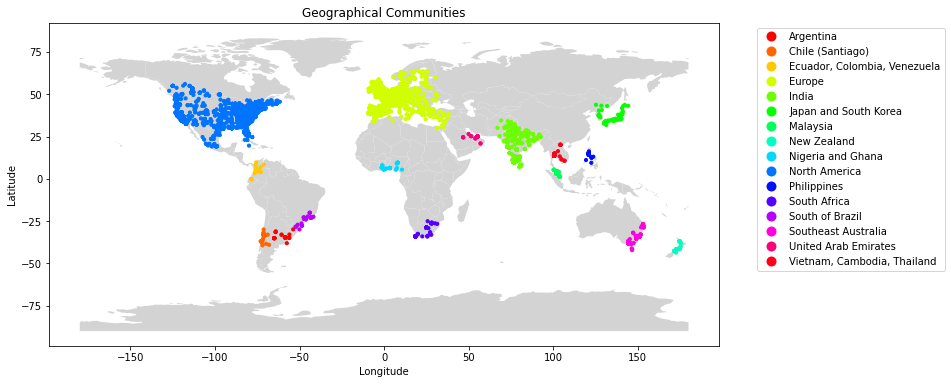

In [39]:
# New DataFrame where noise points are removed
x = tweets_df[tweets_df['cluster_label'] != "Noise"]

# Update latitude and longitude variables
latitude = np.radians([float(coord[0]) for coord in x['coordinates']])
longitude = np.radians([float(coord[1]) for coord in x['coordinates']])

# Convert the DataFrame to a GeoDataFrame
geometry = gpd.points_from_xy(np.degrees(longitude), np.degrees(latitude))
geodf = gpd.GeoDataFrame(x, geometry=geometry)

# Plot the clusters on a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgray')
geodf.plot(column='cluster_label', categorical=True, legend=True, markersize=10, ax=ax, cmap=cm.get_cmap('hsv'))

# Move the legend outside of the plot
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.05, 1))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Communities')
plt.show()


In [26]:
region = {-1: "Noise", 
           0: "Europe", 
           1: "North America", 
           2: "India", 
           3: "Argentina", 
           4: "Vietnam, Cambodia, Thailand", 
           5: "Malaysia", 
           6: "Southeast Australia", 
           7: "South Africa", 
           8: "Japan and South Korea", 
           9: "Philippines", 
          10: "Ecuador, Colombia, Venezuela", 
          11: "Chile (Santiago)", 
          12: "South of Brazil", 
          13: "Nigeria and Ghana", 
          14: "United Arab Emirates", 
          15: "New Zealand"}

users_df["cluster_label"]=users_df["cluster_label"].map(region)
#now run the previous cell again

In [165]:
#Get the tweets and their corresponding community
tweets_df = pd.merge(tweets_df, users_df, on='author', how="inner")

# Geolocated Communities and their attitudes and perceptions

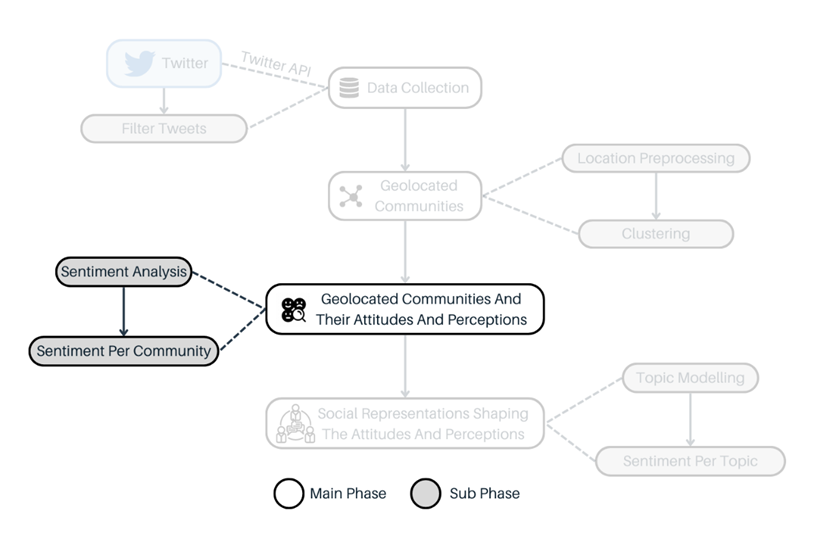

**Sentiment analysis**

In [210]:
MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def sentiment_task(text):
    #first preprocess
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    text= " ".join(new_text)
    
    #Retrieve sentiment from preprocessed text
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    positive_score = scores[2]
    negative_score = scores[0]
    sentiment_score = positive_score - negative_score
    return sentiment_score

In [152]:
tweets_df['sentiment'] = tweets_df['text'].progress_apply(sentiment_task)

100%|██████████████████████████████████████████████████████████████████████████| 33013/33013 [1:20:36<00:00,  6.83it/s]


**Sentiment per community**

In [50]:
result = tweets_df.groupby('cluster_label').size().reset_index(name='Cluster Size')
result = result.merge(tweets_df.groupby('cluster_label').agg({'sentiment': ['mean', 'std']}).reset_index(), on='cluster_label')
result = result.sort_values(by=('sentiment', 'mean'), ascending=False)

# Rename columns
result.columns = ['Region', 'Cluster Size', 'Sentiment (Mean)', 'Sentiment (Std)']

display_df(result[['Cluster Size', 'Region', 'Sentiment (Mean)', 'Sentiment (Std)']])


C:\Users\arthu\AppData\Local\Temp/ipykernel_11796/2020570163.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  result = result.merge(tweets_df.groupby('cluster_label').agg({'sentiment': ['mean', 'std']}).reset_index(), on='cluster_label')
C:\Users\arthu\AppData\Local\Temp/ipykernel_11796/2020570163.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  result = result.merge(tweets_df.groupby('cluster_label').agg({'sentiment': ['mean', 'std']}).reset_index(), on='cluster_label')


,Cluster Size,Region,Sentiment (Mean),Sentiment (Std)
15,83,United Arab Emirates,0.410891,0.292365
5,665,Japan and South Korea,0.406882,0.372077
12,136,South Africa,0.262754,0.413241
11,78,Philippines,0.262558,0.377367
8,50,Nigeria and Ghana,0.256810,0.311818
10,13572,North America,0.244034,0.414379
3,14002,Europe,0.238360,0.470702
13,109,South of Brazil,0.234407,0.419127
16,486,"Vietnam, Cambodia, Thailand",0.217437,0.351495
9,1134,Noise,0.183505,0.457608


# Social representation shaping the attitudes and perceptions

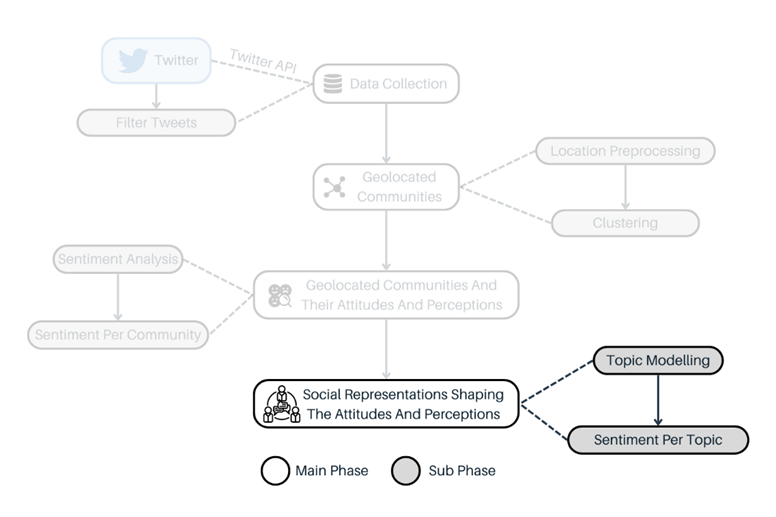

**Topic modelling**

In [47]:
#preprocess

tweets=list(tweets_df["text"])

def preprocess(tweet):
    new_text = []
    for t in tweet.split(" "):
        t = ' ' if t.startswith('@') and len(t) > 1 else t
        t = ' ' if t.startswith('http') else t
        t = ' ' if t.lower()==query else t #remove #vegan because can bias
        new_text.append(t)
    tweet= " ".join(new_text)  
    return tweet

tweets=[preprocess(tweet) for tweet in tweets]

In [ ]:
#Get embeddings
model = SentenceTransformer(model_name_or_path="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(tweets, show_progress_bar=True, batch_size=32)

#dimentionality reduction from 384 to 5 dimentions
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine',random_state=1).fit_transform(embeddings)

In [115]:
#cluster together based on cosine similarity with simalar algorithm as dbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=175,metric='euclidean',cluster_selection_method='eom').fit(umap_embeddings)
#add topic to dataframe
tweets_df['topic'] = cluster.labels_

In [48]:
#we now want to see what the topics are about
docs_df = pd.DataFrame(tweets, columns=["Doc"])
docs_df['Topic'] = tweets_df["topic"]
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# Get the list of all languages supported by the NLTK stopwords corpus
languages = stopwords.fileids()
# Create a custom stop word list that combines stop words from all supported languages
stop_words = []
for language in languages:
    stop_words.extend(stopwords.words(language))

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(tweets))

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
top_n_words[-1]=[('noise', 0)]

C:\Program Files\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қ

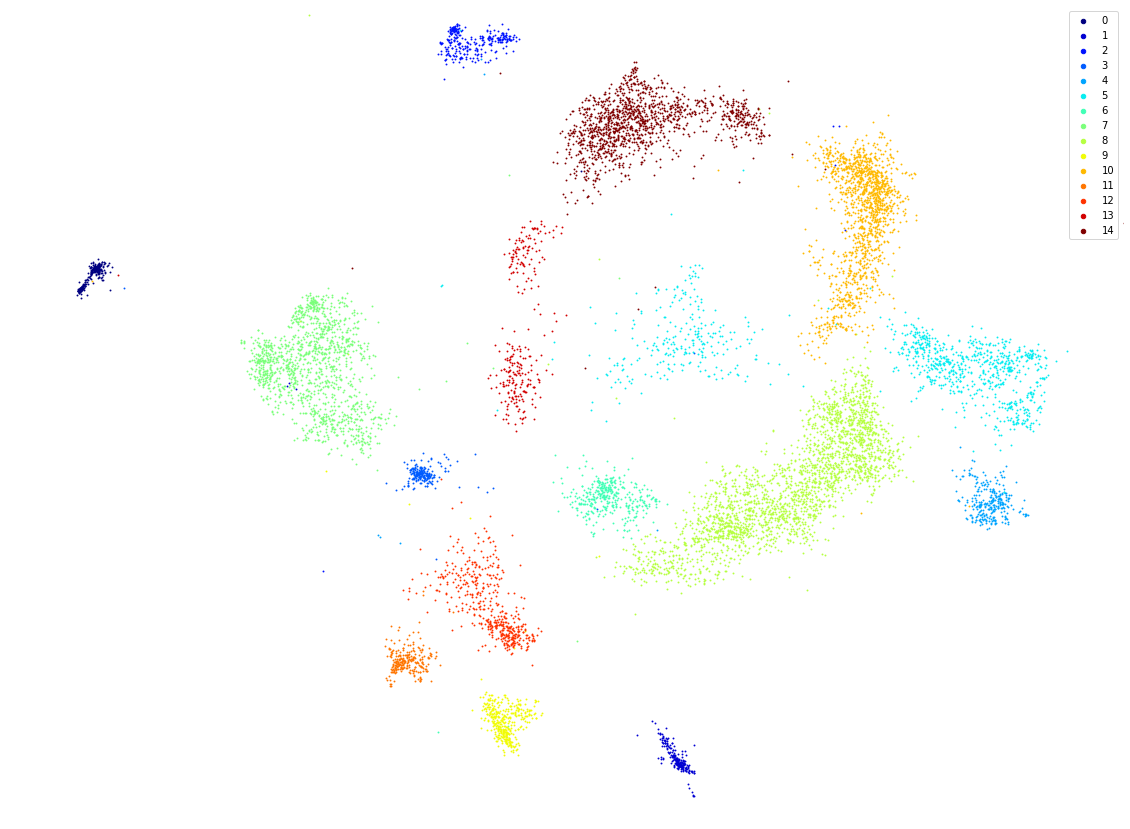

In [147]:
#reduce dimention to 2 so we can plot the clusters that were determined in 5 dimentional space
umap_plot_data = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=3).fit_transform(embeddings)
labels=cluster.labels_

# assuming umap_plot_data and labels are numpy arrays
# filter out the coordinates with label -1
mask = labels != -1
filtered_umap_plot_data = umap_plot_data[mask]
filtered_labels = labels[mask]

x = filtered_umap_plot_data[:, 0]
y = filtered_umap_plot_data[:, 1]

unique_labels = np.unique(filtered_labels)
colors = plt.cm.get_cmap('jet', len(unique_labels))

fig, ax = plt.subplots(figsize=(20, 15))

for i, label in enumerate(unique_labels):
    color = colors(i / (len(unique_labels) - 1))
    mask = filtered_labels == label
    ax.scatter(x[mask], y[mask], c=[color], label=label ,s=0.8)

# adjust the axis limits to zoom in on the points
ax.set_xlim([-1, 12])
ax.set_ylim([-2, 8])

# remove the frame and axis lines
ax.axis('off')

# increase the size of the points in the legend
leg = ax.legend()
for handle in leg.legendHandles:
    handle.set_sizes([20])

plt.show()

**Sentiment per topic**

In [73]:
# Create a dictionary to hold the data
data = {
    'Label': [],
    'Topic Size': [],
    'Most Frequent Words': [],
    'Sentiment (Mean)': [],
    'Sentiment (Std)': []
}

# Iterate over the top_n_words dictionary and populate the data dictionary
for label, words in top_n_words.items():
    data['Label'].append(label)
    data['Topic Size'].append(tweets_df["topic"].value_counts()[label])
    data['Most Frequent Words'].append(', '.join([word[0] for word in words]))  # Join the words with commas
    topic_sentiments = tweets_df[tweets_df["topic"] == label]["sentiment"]
    data['Sentiment (Mean)'].append(topic_sentiments.mean())
    data["Sentiment (Std)"].append(topic_sentiments.std())
    
# Create a pandas DataFrame from the data dictionary
df = pd.DataFrame(data)

# Sort the DataFrame by average sentiment
df = df.sort_values(by='Sentiment (Mean)', ascending=False)

# Print the resulting DataFrame
display_df(df)


,Label,Topic Size,Most Frequent Words,Sentiment (Mean),Sentiment (Std)
14,13,280,"lunch, dinner, weekend, saturday, open",0.514285,0.359587
8,7,1363,"chocolate, cake, cookies, coconut, recipe",0.435970,0.296184
12,11,256,"pasta, noodles, spaghetti, recipe, sauce",0.401892,0.266049
13,12,479,"salad, recipe, dressing, salads, red",0.375659,0.295136
10,9,394,"tofu, rice, sauce, recipe, stir",0.374212,0.287870
1,0,267,"pizza, veganpizza, pizzas, vegan, pepperoni",0.366810,0.367587
4,3,217,"cheese, cheeses, based, plantbased, plant",0.366799,0.405563
7,6,376,"burger, burgers, sandwich, patty, fries",0.355682,0.378229
6,5,1024,"health, healthy, nutrition, diet, healthyfood",0.277909,0.308772
0,-1,22266,noise,0.260272,0.408983
